# Semantic change in LatinISE


Barbara McGillivray

This notebook contains the code for detecting semantic change in the Latin corpus LatinISe using word embeddings.

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [1]:
!pip install gensim==4.0

Import libraries

In [2]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Parameters

I set the parameters of the analysis.

In [3]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [4]:
dir_in = os.path.join("/Users", "barbaramcgillivray", "OneDrive - King's College London", "Research", "2022", "Nexus Linguarum WG4 UC4.2",  "LatinISE")
dir_in

"/Users/barbaramcgillivray/OneDrive - King's College London/Research/2022/Nexus Linguarum WG4 UC4.2/LatinISE"

I define the list of all files:

In [5]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [6]:
len(files)

1146

We only want IntraText files:

In [7]:
files = [f for f in files[:] if "IT" in f]
len(files)

553

I read the metadata file:

In [8]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]

In [9]:
metadata_df.shape

(670, 5)

In [10]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type'], dtype='object')

In [11]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18      382
19       -9
20      524
21     1254
22     1254
       ... 
683     116
684     116
685     116
686     116
687     533
Name: date, Length: 670, dtype: int64>

In [12]:
metadata_df.head

<bound method NDFrame.head of              id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  
18                                          Hieronymus   382  poetry  
19                               Ovidius Naso, Publius    -9  poetry  
20                                Benedictus Nursianus   524   prose  
21                             Thomas Aquinas: Sanctus  1254   prose  
22            

Number of works per year:

In [13]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450     1
-229     1
-199     3
-185     1
-149     2
        ..
 2001    4
 2002    2
 2003    1
 2004    1
 2005    1
Name: id, Length: 263, dtype: int64

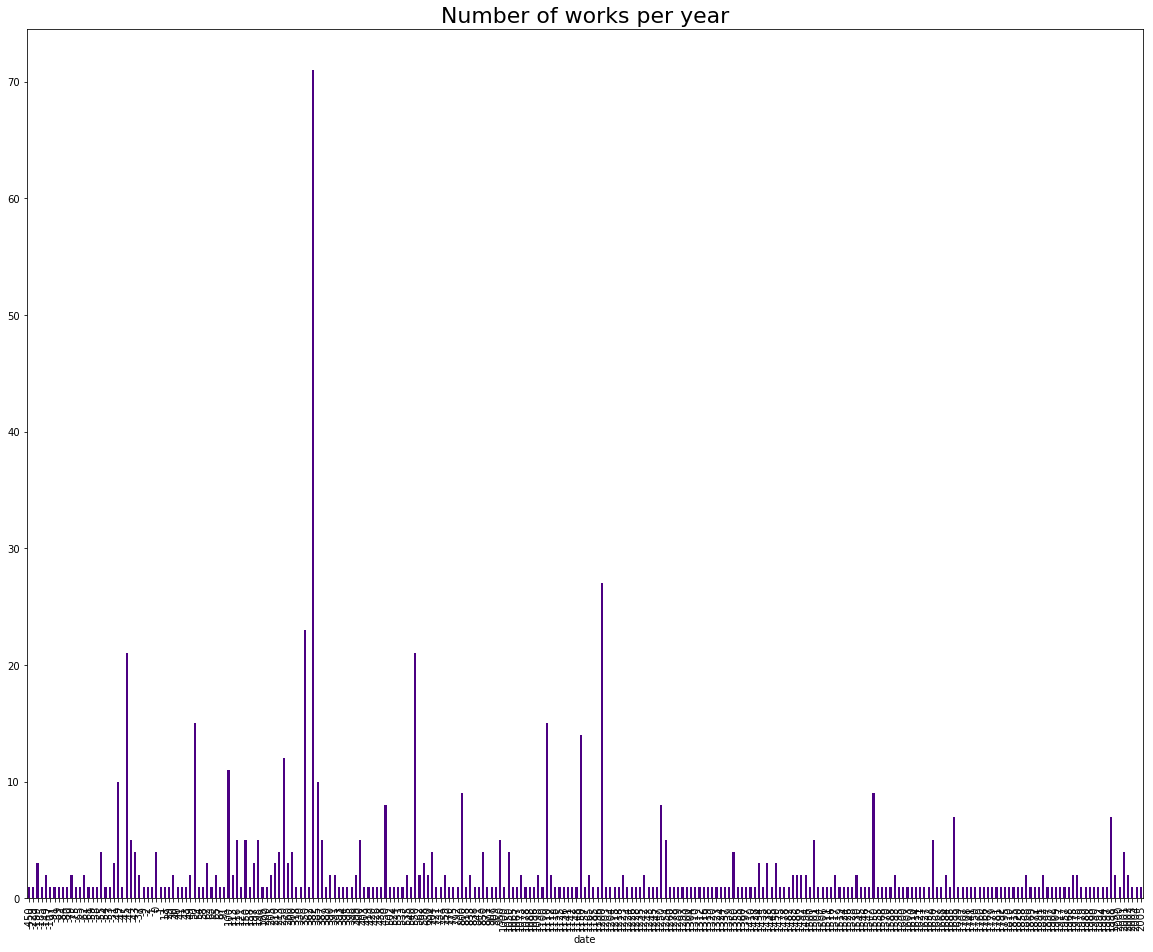

In [14]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

## Split the corpus into subcorpora

Find the first and last year in the dataset:

In [15]:
first_date = min(metadata_df.date)
last_date = max(metadata_df.date)
print(first_date)
print(last_date)

-450
2005


Define size of the time intervals:

In [16]:
size_interval = 500

So there are

In [17]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

5

time intervals.

Define the time periods and split the corpus:

In [18]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)

[-450, 50, 550, 1050, 1550, 2050]


Add a column to the metadata_df for the time interval:

In [19]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, 50)
19      -9
34     -49
38      49
39     -45
42     -49
      ... 
635   -149
638   -107
642    -37
643    -37
649   -229
Name: date, Length: 91, dtype: int64
1
range(50, 550)
18     382
20     524
23     399
24     391
37     158
      ... 
683    116
684    116
685    116
686    116
687    533
Name: date, Length: 236, dtype: int64
2
range(550, 1050)
102    800
104    800
105    800
106    800
107    800
      ... 
601    833
609    598
628    950
634    550
636    550
Name: date, Length: 66, dtype: int64
3
range(1050, 1550)
21     1254
22     1254
25     1224
26     1150
28     1517
       ... 
624    1067
625    1110
626    1110
644    1501
646    1483
Name: date, Length: 178, dtype: int64
4
range(1550, 2050)
27     2000
33     1998
35     2001
36     1992
220    1998
       ... 
641    1685
647    1550
650    1555
651    1684
652    1684
Name: date, Length: 99, dtype: int64


,id,title,creator,date,type,time_interval
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,50
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,-450
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,50
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,1050
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,1050
...,...,...,...,...,...,...
683,IT-LAT0534,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
684,IT-LAT0534,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
685,IT-LAT0534,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
686,IT-LAT0534,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,50


Visualise distribution of time intervals:

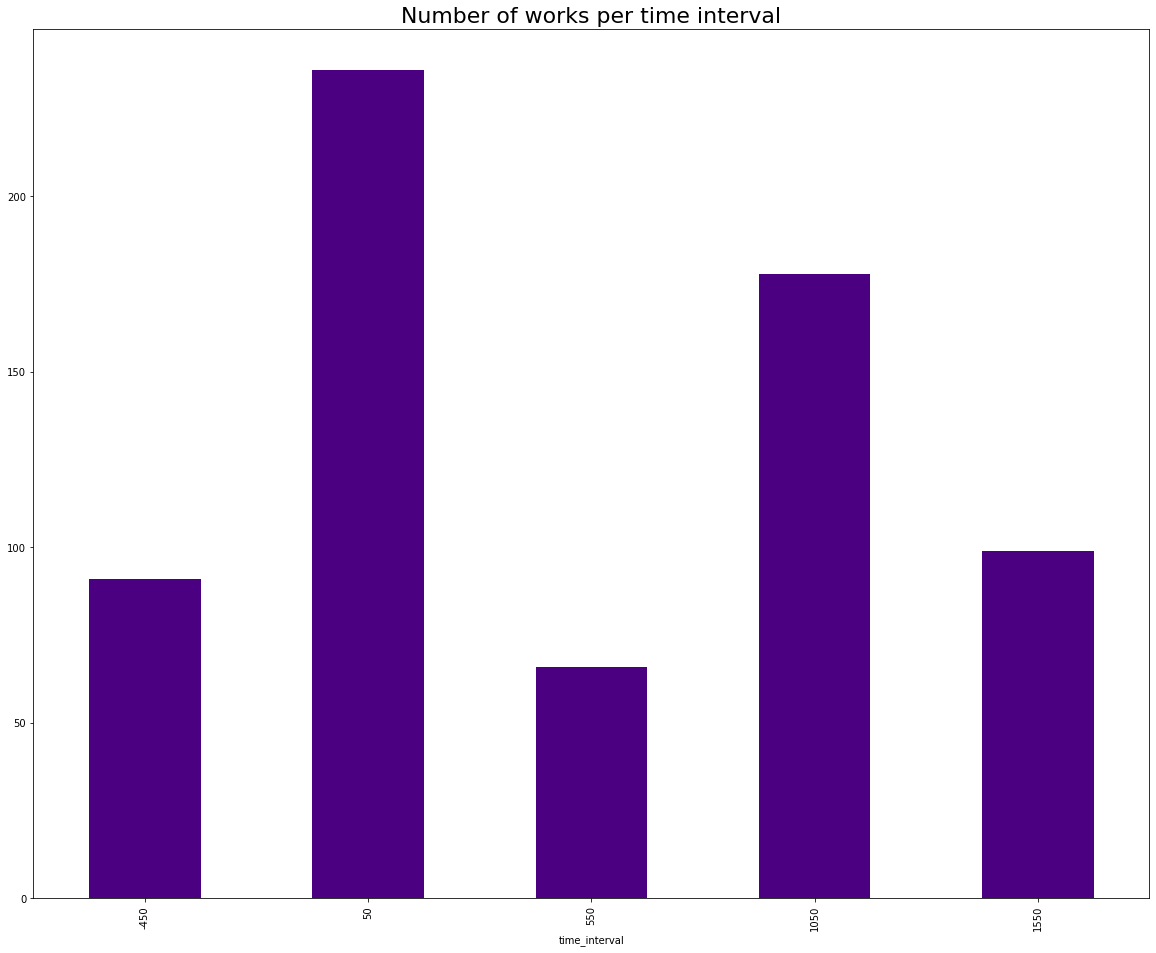

In [20]:
metadata_df0 = metadata_df.groupby(['time_interval']).count()
metadata_df0 = metadata_df0['id']
metadata_df0
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

WE MAY WANT TO DO SOMETHING ABOUT THIS INBALANCE

## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [21]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [22]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [23]:
punctuation = ['.', ',', '...', ';', ':']

I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [24]:
corpus = list()
files_corpus = metadata_df
for index, df_line in files_corpus.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    #print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus.append(sentences_this_file)

In [25]:
metadata_df

,id,title,creator,date,type,time_interval
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,50
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,-450
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,50
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,1050
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,1050
...,...,...,...,...,...,...
683,IT-LAT0534,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
684,IT-LAT0534,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
685,IT-LAT0534,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
686,IT-LAT0534,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,50


In [26]:
corpus

[['ars',
  'amatorius',
  'Siquis',
  'in',
  'hic',
  'ars',
  'populus',
  'non',
  'nosco',
  'amo',
  'hic',
  'lego#2',
  'et',
  'lectus',
  'carmen',
  'doceo',
  'amo'],
 ['ars',
  'cieo',
  'veloque',
  'rates',
  'remoque',
  'moveo',
  'ars',
  'levis',
  'currus',
  'ars',
  'rego',
  'amor'],
 ['currus',
  'Automedon',
  'lentisque',
  'sum',
  'aptus',
  'habena',
  'Tiphys',
  'in',
  'Haemonia',
  'puppe',
  'magister',
  'sum',
  'ego',
  'Venus',
  'artifex',
  'tener',
  'praeficio',
  'amor',
  'Tiphys',
  'et',
  'Automedon',
  'dico#2',
  'amor',
  'ego'],
 ['ille',
  'quidem',
  'ferus',
  'sum',
  'et',
  'quis#2',
  'ego',
  'saepe',
  'repugno',
  'sed',
  'puer',
  'sum',
  'aetas',
  'mollis',
  'et',
  'aptus',
  'rex'],
 ['Phillyrides',
  'puer',
  'cithara',
  'perficio',
  'Achillem',
  'atque',
  'animus',
  'placidus',
  'contundo',
  'ars',
  'ferus'],
 ['qui',
  'totiens',
  'socius',
  'totiens',
  'exterruit',
  'hostis',
  'credo',
  'annosus',
  

Function for training FastText models (from Krzysztof Nowak):

In [27]:
def fasttext(self, opts=dict()):
        """
        Reads sentences from the corpus. Implements:
            https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText
        Returns
        -------
        FastText model
        """
        default_opts = dict(vector_size=100, alpha=0.025,
                            window=5, min_count=5, epochs=5)
        opts_new = default_opts
        for opt in opts.keys():
            opts_new[opt] = opts[opt]
        model = FastText(
            vector_size=opts_new["vector_size"],
            alpha=opts_new["alpha"],
            window=opts_new["window"],
            min_count=opts_new["min_count"])
        model.build_vocab(corpus_iterable=[sentence for sentence in
                                           self.corpus.get_sents()])
        total_examples = model.corpus_count
        model.train(corpus_iterable=[sentence for sentence
                                     in self.corpus.get_sents()],
                    total_examples=total_examples,
                    epochs=opts_new["epochs"])
        return model

Parameters: 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020) or 5 following Sprugnoli et al. (2019).

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [28]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(31084184, 41666430)

Let's see what words are similar to "dies":

In [29]:
model.wv.similar_by_word('dies', 10)

[('hora', 0.6752183437347412),
 ('mensis', 0.6474769711494446),
 ('meridies', 0.6428548693656921),
 ('annus', 0.6377666592597961),
 ('quadragesima', 0.6296699643135071),
 ('triduum', 0.61091548204422),
 ('quadragesimus', 0.6022071242332458),
 ('quadriduum', 0.5993087887763977),
 ('mensium', 0.5837174654006958),
 ('ann', 0.5785283446311951)]

Let's try with different parameters:

In [30]:
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 515 seconds


[('diesim', 0.9309508204460144),
 ('indies', 0.8473234176635742),
 ('meridies', 0.7684506177902222),
 ('diescit', 0.7626093029975891),
 ('octies', 0.7305119633674622),
 ('novies', 0.7198655009269714),
 ('diesque', 0.7152551412582397),
 ('hora', 0.714570164680481),
 ('mensis', 0.6874949336051941),
 ('triduum', 0.6779671311378479)]

In [31]:
start = time.time()
model = FastText(vector_size=100, window=10, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 725 seconds


[('diesim', 0.9379062056541443),
 ('indies', 0.8583981394767761),
 ('diescit', 0.7836390733718872),
 ('meridies', 0.7503916621208191),
 ('diesque', 0.740541934967041),
 ('octies', 0.7344682812690735),
 ('novies', 0.7120219469070435),
 ('hora', 0.7067863941192627),
 ('diecula', 0.6771037578582764),
 ('sexies', 0.6731992959976196)]

I evaluate different configurations of the parameters for the embeddings against the gold standard set by Sprugnoli et al. (2019) (https://github.com/CIRCSE/Lemma-Embeddings-for-Latin/blob/master/syn-selection-benchmark-Latin.tsv) to find the best configuration of parameters:

https://gitlab.surrey.ac.uk/mr0048/pydigest/-/blob/master/script/fasttext_003.py

WE MAY ALSO WANT TO EVALUATE THE TIME-INSENSITIVE EMBEDDINGS (i.e. trained of the full corpus) similarly to Ribary & McGillivray (2020)

## Training embeddings for each time interval

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [33]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
for t in range(n_intervals+1):
    files_corpus_t = metadata_df.loc[metadata_df['time_interval'] == intervals[t]]
    #print("1:",files_corpus_t, type(files_corpus_t))
    corpus_t = list()
    for index, df_line in files_corpus_t.iterrows():
        #print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus[t] = corpus_t


Let's inspect the corpus for the first time interval:

In [34]:
time2corpus[0]

[['ars',
  'amatorius',
  'Siquis',
  'in',
  'hic',
  'ars',
  'populus',
  'non',
  'nosco',
  'amo',
  'hic',
  'lego#2',
  'et',
  'lectus',
  'carmen',
  'doceo',
  'amo'],
 ['ars',
  'cieo',
  'veloque',
  'rates',
  'remoque',
  'moveo',
  'ars',
  'levis',
  'currus',
  'ars',
  'rego',
  'amor'],
 ['currus',
  'Automedon',
  'lentisque',
  'sum',
  'aptus',
  'habena',
  'Tiphys',
  'in',
  'Haemonia',
  'puppe',
  'magister',
  'sum',
  'ego',
  'Venus',
  'artifex',
  'tener',
  'praeficio',
  'amor',
  'Tiphys',
  'et',
  'Automedon',
  'dico#2',
  'amor',
  'ego'],
 ['ille',
  'quidem',
  'ferus',
  'sum',
  'et',
  'quis#2',
  'ego',
  'saepe',
  'repugno',
  'sed',
  'puer',
  'sum',
  'aetas',
  'mollis',
  'et',
  'aptus',
  'rex'],
 ['Phillyrides',
  'puer',
  'cithara',
  'perficio',
  'Achillem',
  'atque',
  'animus',
  'placidus',
  'contundo',
  'ars',
  'ferus'],
 ['qui',
  'totiens',
  'socius',
  'totiens',
  'exterruit',
  'hostis',
  'credo',
  'annosus',
  

And the second:

In [35]:
time2corpus[1]

[['obsculta',
  'o',
  'filius',
  'praeceptum',
  'magister',
  'et',
  'inclino',
  'auris',
  'cor',
  'tuus',
  'et',
  'admonitio',
  'pius',
  'pater',
  'libet',
  'excipe',
  'et',
  'efficaciter',
  'comple',
  'ut',
  'ad',
  'is',
  'per',
  'oboedientia',
  'labor',
  'redeo',
  'ab',
  'quo',
  'per',
  'inoboedientia',
  'desidia',
  'recedo'],
 ['ad',
  'tu',
  'ergo',
  'nunc',
  'ego',
  'sermo',
  'dirigo',
  'quisquis',
  'abrenuntio',
  'proprius',
  'voluntas',
  'dominus',
  'Christus',
  'verus',
  'rex',
  'militaturus',
  'oboedientia',
  'fortis',
  'atque',
  'praeclarus',
  'arma',
  'sumo'],
 ['in',
  'primus',
  'ut',
  'quisquis',
  'ago',
  'inchoas',
  'bonus',
  'ab',
  'is',
  'perficio',
  'instantissima',
  'oratio',
  'deposco',
  'ut',
  'quis#2',
  'nos',
  'iam',
  'in',
  'filius',
  'dignor',
  'sum',
  'numerus',
  'computo',
  'non',
  'debeo',
  'aliquando',
  'de',
  'malus',
  'actus',
  'noster',
  'contristo'],
 ['ita',
  'enim',
  'is'

And the third:

In [36]:
time2corpus[2]

[['conflictus',
  'VERIS',
  'et',
  'HIEMIS',
  'convenio',
  'subito',
  'cunctus',
  'de',
  'mons',
  'altus',
  'pastor',
  'pecudum',
  'vernalis',
  'lux',
  'sub',
  'umbra',
  'arboreus',
  'pariter',
  'laetus',
  'celebro',
  'Camena'],
 ['adsum',
  'et',
  'iuvenis',
  'Dafnis',
  'seniorque',
  'Palemon',
  'omnis',
  'hic',
  'cuculus',
  'laus',
  'canto',
  'paro#2'],
 ['ver',
  'quoque',
  'florigero',
  'succingo',
  'stemmate',
  'venio',
  'frigidus',
  'venio',
  'hiem(p)s',
  'rigida',
  'hirsutus',
  'capillus'],
 ['hic', 'certamen', 'sum', 'cuculus', 'de', 'carmen', 'grandis'],
 ['ver', 'prior', 'adlusit', 'terni', 'modulamine', 'versus'],
 ['Ver', 'opto', 'meus', 'venio', 'cuculus', 'carus', 'alo'],
 ['omnis',
  'iste',
  'solo',
  'fio',
  'gratus',
  'hospes',
  'in',
  'tectum',
  'modulor',
  'rutilus',
  'bonus',
  'carmen',
  'rostrum'],
 ['hiem(p)s',
  'tum',
  'glacialis',
  'hiem(p)s',
  'respondeo',
  'vox',
  'severus',
  'non',
  'venio',
  'cuculus

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

Start with the first subcorpus:

In [38]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 267 seconds


[('meridies', 0.9163129329681396),
 ('abies', 0.7936743497848511),
 ('sies', 0.7729646563529968),
 ('rabies', 0.7646446824073792),
 ('annuo', 0.7210932374000549),
 ('series', 0.7157571911811829),
 ('diesque', 0.7051329016685486),
 ('annuum', 0.7037642598152161),
 ('planities', 0.653698742389679),
 ('sanies', 0.6453130841255188)]

In [39]:
print_vocab(model, 10)

word #0/12031 is sum
word #1/12031 is et
word #2/12031 is in
word #3/12031 is quis#2
word #4/12031 is is
word #5/12031 is cum
word #6/12031 is non
word #7/12031 is hic
word #8/12031 is ad


I now check the similar words to "sum":

In [40]:
model.wv.similar_by_word('sum', 10)

[('sume', 0.8416870832443237),
 ('asum', 0.8006221652030945),
 ('sumne', 0.7785760164260864),
 ('adsum', 0.7509841322898865),
 ('ausum', 0.72687828540802),
 ('sumo', 0.725217342376709),
 ('desum', 0.7057944536209106),
 ('Thapsum', 0.7038236856460571),
 ('Salsum', 0.7017993330955505),
 ('Chersonesum', 0.7004284262657166)]

I now train one model for each time interval:

In [41]:
len(time2corpus)

6

In [42]:
models = list()
start = time.time()
for t in range(len(time2corpus)):
    print(t)
    if len(time2corpus[t])>0:
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=4, min_count=5, workers=1, seed=1,hashfxn=hash)  # instantiate
        model.build_vocab(corpus_iterable=time2corpus[t])
        model.train(corpus_iterable=time2corpus[t], total_examples=len(time2corpus[t]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds")

0
1
2
3
4
5
It has taken 2192 seconds


Let's check some models:

In [43]:
print_vocab(models[0], 20)

word #0/12031 is sum
word #1/12031 is et
word #2/12031 is in
word #3/12031 is quis#2
word #4/12031 is is
word #5/12031 is cum
word #6/12031 is non
word #7/12031 is hic
word #8/12031 is ad
word #9/12031 is ut
word #10/12031 is ab
word #11/12031 is quod
word #12/12031 is si
word #13/12031 is omnis
word #14/12031 is ex
word #15/12031 is atque
word #16/12031 is se
word #17/12031 is res
word #18/12031 is quam#4


In [44]:
models[0].wv.similar_by_word('dies', 10)

[('meridies', 0.8714439272880554),
 ('sies', 0.7241136431694031),
 ('abies', 0.7221601605415344),
 ('diesque', 0.7073634266853333),
 ('rabies', 0.658245325088501),
 ('annuum', 0.620093047618866),
 ('sanies', 0.6032583117485046),
 ('series', 0.5970252752304077),
 ('annuo', 0.5896868705749512),
 ('annus', 0.5853093862533569)]

In [45]:
print_vocab(models[1], 20)

word #0/20026 is et
word #1/20026 is sum
word #2/20026 is in
word #3/20026 is quis#2
word #4/20026 is is
word #5/20026 is non
word #6/20026 is ab
word #7/20026 is hic
word #8/20026 is ut
word #9/20026 is ad
word #10/20026 is cum
word #11/20026 is si
word #12/20026 is quod
word #13/20026 is sed
word #14/20026 is ex
word #15/20026 is ille
word #16/20026 is atque
word #17/20026 is omnis
word #18/20026 is ipse


In [46]:
models[1].wv.similar_by_word('dies', 10)

[('meridies', 0.7701682448387146),
 ('octies', 0.7644561529159546),
 ('fies', 0.7439697980880737),
 ('novies', 0.7115722894668579),
 ('hora', 0.666756808757782),
 ('abies', 0.6411404609680176),
 ('quadragies', 0.6374448537826538),
 ('series', 0.6277113556861877),
 ('annus', 0.620319128036499),
 ('requies', 0.6200743913650513)]

In [47]:
models[4].wv.similar_by_word('dies', 10)

[('meridies', 0.8791937232017517),
 ('novies', 0.7960880994796753),
 ('annulo', 0.7322573661804199),
 ('annuo', 0.7219036221504211),
 ('hebdomada', 0.7134909629821777),
 ('hebdomades', 0.7075924277305603),
 ('diesque', 0.7024726271629333),
 ('annus', 0.7013199329376221),
 ('hebdomadae', 0.6898954510688782),
 ('hora', 0.6856685280799866)]

##  Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords https://github.com/williamleif/histwords.

First, I define a function to find the intersection between the vocabularies of two word2vec models:



In [50]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

Now I can apply the function to my models:

Then, I define a function for aligning two spaces with Orthogonal Procrustes:

In [51]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # re-filling the normed vectors: the following two lines were added following Japleen Gulati, following amacanovic's comments in the discussion below this page: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)
    
    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed


In [52]:
smart_procrustes_align_gensim(models[0], models[1])

9377 9377
9377 9377


In [53]:
smart_procrustes_align_gensim(models[2], models[0])

5267 5267
5267 5267


I align all models:

In [54]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models)-1):
    reduce(smart_procrustes_align_gensim, models)
    

5267 5267
5267 5267
5005 5005
5005 5005
4702 4702
4702 4702
5005 5005
5005 5005
4702 4702
4702 4702
5005 5005
5005 5005
4702 4702
4702 4702
4702 4702
4702 4702


Now the models have been aligned and have the same vocabulary:

In [55]:
for i in range(0,len(models)):
    print(i, len(models[i].wv.index_to_key))

0 4702
1 4702
2 4702
3 4702
4 4702


# Semantic change with cosine similarity

## Step 4: Measure change

Now I can measure the cosine similarity between the embedding of a word in each time period"

Let's define a function that calculates the cosine similarity between the embedding of a word in a time interval t and the embedding of the same word in the first time interval:

In [57]:
def cosine_similarity(word, t):
  sc = 1-spatial.distance.cosine(models[t].wv[word], models[0].wv[word])
  return sc

Now I calculate the semantic similarity for all words in the vocabulary, and store this in the dataframe cosine_similarity; I also add a column for the frequency of the word in the first space and another one for its frequency in the second space:

In [58]:
cosine_similarity_df = pd.DataFrame(([w, 
                                      models[0].wv.get_vecattr(w, "count") , 
                                      models[1].wv.get_vecattr(w, "count"),
                                      models[2].wv.get_vecattr(w, "count"),
                                      models[3].wv.get_vecattr(w, "count"),
                                      models[4].wv.get_vecattr(w, "count"),
                                    cosine_similarity(w,1), 
                                    cosine_similarity(w,2), 
                                    cosine_similarity(w,3), 
                                    cosine_similarity(w,4), 
                                     ] for w in models[i].wv.index_to_key), 
                                    columns = ('Word', "Frequency_t0", "Frequency_t1", "Frequency_t2", "Frequency_t3", "Frequency_t4",
                                              'Cosine_similarity(w_t0,w_t1)', 'Cosine_similarity(w_t0,w_t2)', 'Cosine_similarity(w_t0,w_t3)', 'Cosine_similarity(w_t0,w_t4)', 
                                              ))
cosine_similarity_df

,Word,Frequency_t0,Frequency_t1,Frequency_t2,Frequency_t3,Frequency_t4,"Cosine_similarity(w_t0,w_t1)","Cosine_similarity(w_t0,w_t2)","Cosine_similarity(w_t0,w_t3)","Cosine_similarity(w_t0,w_t4)"
0,et,37761,73054,19742,88984,44151,0.748305,0.199814,0.191367,-0.036353
1,sum,56841,88042,22854,78725,33401,0.808079,0.359624,0.171095,0.116044
2,in,33263,49056,15289,49210,31832,0.774969,0.402780,0.172334,-0.140234
3,quis#2,32427,46301,12464,41107,22130,0.840982,0.460089,0.244650,0.186640
4,is,28178,35023,11237,33584,18535,0.813966,0.507874,0.323673,0.116039
...,...,...,...,...,...,...,...,...,...,...
4697,pacemque,23,48,12,38,23,0.865758,0.295834,0.128612,0.150263
4698,flamen,27,56,13,39,23,0.749940,0.305904,0.046690,0.267188
4699,insedit,24,50,12,38,23,0.758634,0.589924,0.512500,0.583560
4700,recubo,23,49,12,37,23,0.788746,0.515112,0.541787,0.417980


Visualise the distribution of the semantic similarity scores with a histogram:

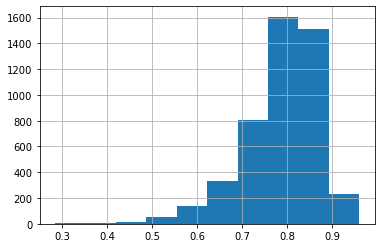

In [59]:
hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()

I've STOPPED HERE!!! see https://colab.research.google.com/drive/1ZNyuPKO3CZwyoYNpBHmPpvv7Yl2rtj89#scrollTo=yeUCSbrVJGQd

In [ ]:
cosine_ref_year_next_years = dict() # dictionary of lists: if reference_step is "first", first list corresponds 
# to reference year considered (first_year+year_intervals), 
#second list to first_year+2*year_intervals, etc.; 
# maps a word to the list of cosines between the embeddings for this word in reference year 
# and the embeddings for the same word in each of the other years
common_words = list() # list of words present in all of the years
range_years = list()
neighbours_ref_year_next_years = dict() # maps a word to a triple of lists for each year: 
# the first element of the triple is the list of top 10 nearest neighbours to the 
# embedding for that word in the reference year;
# the second element of the triple is the list of top 10 nearest neighbours to the 
# embedding for the same word in one of the other years;
# the third element of the triple is the overlap between the two lists above;

if reference_step == "first":
    #range_years = range(first_year+year_intervals, last_year, year_intervals)
    range_intervals = range(intervals[0])
    #reference_year = first_year
elif reference_step == "last":
    #range_years = range(first_year, last_year-year_intervals, year_intervals)
    range_intervals = range(first_year, last_year-year_intervals, year_intervals)
    #reference_year = last_year-year_intervals+1
    reference_year = last_year-year_intervals+1
    
for year in range_years:
  print("Year", str(year), "with", str(reference_year))
  (common_vocab_1_2,common_vocab_matrix_1,common_vocab_matrix_2) = intersection_align(all_embeddings[reference_year],all_embeddings[year])
  if len(common_fields) == 0:
    common_fields = common_vocab_1_2
  else:
    common_fields = [f for f in common_vocab_1_2 if f in common_fields]
    print(str(len(common_fields)), "Common fields so far: ", str(common_fields))
  #print("I align the spaces of fields in year " + str(reference_year) + " and " + str(year))
  new_1, new_2 = smart_procrustes_align(all_embeddings[reference_year], all_embeddings[year], num_dimensions)
  cosine_list = list()
  neighbours_list = list()
  for field_index in range(len(common_vocab_1_2)):
    field = common_vocab_1_2[field_index]
    #print("Shared field number " + str(field_index) + ": " + field)
    cosine = cosine_similarity([new_1[field_index]], [new_2[field_index]])
    cosine_list.append(cosine)
    #if cosine < 0.5:
    #  print("This FoR has changed (cosine = ", str(cosine), ")")
    #else:
    #  print("This FoR has not changed (cosine = ", str(cosine), ")")
    #print("Finding top 5 nearest neighbours for " + field + " in year " + str(year))
    neighbours_year = nearest_neighbours(5,year, all_embeddings, field)
    #print(str(neighbours_year))
    #print("Finding top 5 nearest neighbours for " + field + " in year " + str(reference_year))
    neighbours_reference_year = nearest_neighbours(5,reference_year, all_embeddings, field)
    #print(str(neighbours_reference_year))
    overlap_neighbours = [n for n in neighbours_year if n in neighbours_reference_year]
    #print("Finding overlap: " + str(overlap_neighbours))
    neighbours_list.append([neighbours_reference_year, neighbours_year, overlap_neighbours])
    #print("\n\n")
  
  cosine_ref_year_next_years[year] = cosine_list
  neighbours_ref_year_next_years[year] = neighbours_list
common_fields = list(set(common_fields))
print(str(len(common_fields)), "Common fields across all years: ", str(common_fields))

Now I sort by decreasing semantic change score:

In [ ]:
cosine_similarity_df_sorted = cosine_similarity_df.sort_values(by='Cosine_similarity', ascending=True)
cosine_similarity_df_sorted.head()

I add the total frequency:

In [ ]:
cosine_similarity_df_sorted["Total_Frequency"] = cosine_similarity_df_sorted["Frequency_t1"]+cosine_similarity_df_sorted["Frequency_t2"]
cosine_similarity_df_sorted

I add a column with the category (function word, foreign word, numeral, and proper noun).

List of function words (from https://www.eltconcourse.com/training/initial/lexis/function_words.html)

In [ ]:
function_words = ['after', 'although', 'and', 'as', 'because', 'before', 'both', 'but', 'either', 'for', 'however', 'if','neither','nor','once','or','since','so','than','that','therefore','though','thus','till','unless','until','when','whenever','where','wherever','whether','while','yet	a','all','another','any','both','each','either','every','her','his','its','my','neither','no','other','our','per','some','that','the','their','these','this','those','whatever','whichever','your	about','above','across','after','against','ahead','along','among','amongst','around','as','at','bar','before','behind','below','beneath','beside','besides','between','beyond','but','by','down','during','except','for','from','in','inside','into','less','like	near','of','off','on','onto','opposite','outside','over','past','per','round','save','since','through','till','to','toward','under','underneath','until','up','upon','with','within','without	all','another','any','anybody','anyone','anything','both','each','either','everybody','everyone','everything','few','he','I','it','many','mine','neither','nobody','none','nothing','one','other','several','she','some','somebody','someone','something','that','these','they	this','those','we','what','whatever','which','whichever','who','whoever','whom','whose','you']

Applying the detect package doesn't work on individual words so I use the NLTK's English dictionary instead:

In [ ]:
#semantic_change.df.sorted['Language'] = semantic_change.df.sorted['Word'].apply(detect) 
import nltk
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
len(english_vocab)

In [ ]:
# create a list of our conditions
conditions = [
    (cosine_similarity_df_sorted['Word'].isin(function_words)), # function words
    ((cosine_similarity_df_sorted.Word.str.isdigit()) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?1st$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?2nd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?3rd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (cosine_similarity_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(cosine_similarity_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
cosine_similarity_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
cosine_similarity_df_sorted

I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
cosine_similarity_df_sorted.to_csv(os.path.join(output_folder, 'Cosine_similarity_all_words.csv'), encoding='utf-8')

The top most changed words:

In [ ]:
cosine_similarity_df_sorted.head(100)

In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] =="scientist"]

I plot the terms by their total frequency and semantic change score:

In [ ]:
ax = cosine_similarity_df_sorted.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

Which words are the outliers? Function words and *Darwin*:

In [ ]:
cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] > 10000].Word.tolist()

I exclude the outliers:

In [ ]:
cosine_similarity_df_sorted_nooutliers = cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] < 10000]
cosine_similarity_df_sorted_nooutliers.shape

Plot:

In [ ]:
ax = cosine_similarity_df_sorted_nooutliers.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

What is the semantic change of the words we have chosen?

In [ ]:
words_chosen = ['protoplasm', 'curious', 'fertilisation', 'fertilise', 'analogy', 'analogous', 'homology', 'homologous', 'cleistogamic', 'physiology', 'physiological', 'ferment', 'science', 'scientist', 'scientific', 'evolution', 'evolutionary', 'evolve']

In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] == "scientist"]


In [ ]:
cosine_similarity_chosen = cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'].isin(words_chosen)]
cosine_similarity_chosen.to_csv(os.path.join(output_folder, 'cosine_similarity_chosen_words.csv'), encoding='utf-8')
cosine_similarity_chosen

In [ ]:
min(cosine_similarity_chosen.Cosine_similarity)

In [ ]:
min(cosine_similarity_chosen.Total_Frequency)

In [ ]:
min(cosine_similarity_df_sorted.Cosine_similarity)

Now I focus on those words that have a frequency higher than min(semantic_change_chosen.Total_Frequency). How many are there?

In [ ]:
cosine_similarity_df_sorted_filtered = cosine_similarity_df_sorted_nooutliers.loc[(cosine_similarity_df_sorted_nooutliers['Total_Frequency'] >= min(cosine_similarity_chosen.Total_Frequency))]
cosine_similarity_df_sorted_filtered.shape

Which words are these words?

In [ ]:
cosine_similarity_df_sorted_filtered

Neighbours of *fertilisation* in the two time periods:

In [ ]:
print(model1.wv.similar_by_word("fertilisation", 10))
print(model2.wv.similar_by_word("fertilisation", 10))
cosine_similarity_df_sorted_filtered[cosine_similarity_df_sorted_filtered['Word'] == "fertilisation"]

I create a list for these words:

In [ ]:
highfreq_words = cosine_similarity_df_sorted_filtered.Word.tolist()
highfreq_words[:10]

Now I annotate the plot with these:

In [ ]:
cosine_similarity_df_sorted_filtered_p = cosine_similarity_df_sorted_filtered[['Word','Cosine_similarity', 'Total_Frequency']]
fig, ax = plt.subplots()
cosine_similarity_df_sorted_filtered_p.plot('Cosine_similarity', 'Total_Frequency', kind='scatter', ax=ax)
for k, v in cosine_similarity_df_sorted_filtered_p.iterrows():
  word = v['Word']
  sc = v['Cosine_similarity']
  f = v['Total_Frequency']
  #print("w", v['Word'])
  #print("sc:", str(sc))
  #print("f:", str(f))
  ax.annotate(word, xy=(sc,f))

What are the neighbours of these words in the two spaces?

In [ ]:
count = 0
for word in highfreq_words:
  count += 1
  if count < 10:
    print(word)
    print("Neighbours in first space:")
    print(model1.wv.similar_by_word(word, 10))
    print("Neighbours in second space:")
    print(model2.wv.similar_by_word(word, 10))

I print this to an output file:

In [ ]:
outfile = open(os.path.join(output_folder, 'Neighbours_freq_words.csv'), 'w+')

# Write header row:
outfile.write("Word, followed by  neighbours in first space and neighbours in second space\n") 
for word in highfreq_words:
  #print(word)
  #print("Neighbours in first space:")
  #print(model1.wv.similar_by_word(word, 10))
  #print("Neighbours in second space:")
  #print(model2.wv.similar_by_word(word, 10))
  for (w,c) in model1.wv.similar_by_word(word, 10):
    outfile.write(word+"\t" + w+"\t"+str(c))
  outfile.write("\n")
  for (w,c) in model2.wv.similar_by_word(word, 10):
    outfile.write(word+"\t"+w+"\t"+str(c))
  outfile.write("\n")
  
outfile.close()

## Semantic change detection using neighbours

We're going to implement the method proposed by Gonen, H., Jawahar, G., Seddah, D., & Goldberg, Y. (2020). Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics (pp. 538–555). https://doi.org/10.18653/v1/2020.acl-main.51 

Print the histogram of the frequency of the words in the corpus:

In [ ]:
model = sg_w5_f1
vocab = model.wv.index_to_key
frequencies = list()
for w in vocab:
  frequencies.append(model.wv.get_vecattr(w, "count"))
print(pd.DataFrame({'Word':vocab,'Freq':frequencies}).describe())
pd.DataFrame({'Word':vocab,'Freq':frequencies}).hist()

I exclude all words with frequency lower than min_freq and higher than max_freq:

In [ ]:
def filter_words(model, min_freq, max_freq):
  vocab = model.wv.index_to_key
  vocab_filtered = []
  for w in vocab:
    if model.wv.get_vecattr(w, "count") <max_freq and model.wv.get_vecattr(w, "count")>min_freq:
      vocab_filtered.append(w)
  return vocab_filtered

vocab1_filtered = filter_words(model1,2,50000)
vocab2_filtered = filter_words(model2,2,50000)
vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))

How many words?

In [ ]:
print(str(len(vocab_filtered)))

Distribution of filtered word frequencies:

In [ ]:
word2freq = pd.DataFrame({'Word':vocab,'Freq':frequencies})
print(word2freq[(word2freq.Freq<100000) & (word2freq.Freq>3)].describe())
word2freq[(word2freq.Freq<50000) & (word2freq.Freq>2)].hist()

I extract the top_n neighbours and save them in a dictionary mapping a word to the list of its 100 neighbours:

In [ ]:
def extract_neighbours(w2vmodel, vocab_list, top_n):
  count = 0
  word2neighbours = dict()
  for w in vocab_list:
    count += 1
    #if (count % 100) == 0:
    #  print(str(count), "out of", str(len(vocab_list)), w)
    neighbours = w2vmodel.wv.similar_by_word(w, top_n)
    #print(str(neighbours))
    neighbour_list = list()
    for n in neighbours:
      neighbour_list.append(n[0])
    word2neighbours[w] = neighbour_list
  return word2neighbours

I apply this to model1 and model2 for filtered words:

In [ ]:
#word2neighbours1 = extract_neighbours(model1, model1.wv.index_to_key)
word2neighbours1 = extract_neighbours(model1, vocab1_filtered, 100)
#word2neighbours2 = extract_neighbours(model2, model2.wv.index_to_key)
word2neighbours2 = extract_neighbours(model2, vocab2_filtered, 100)

For every word in the intersection between the two vocabularies, compare its neighbours in t1 and its neighbours in t2; the semantic change score is the number of shared neighbours between the two divided by 100.
NB This is different from the formula in Gonen et al. (2020), who take the negative of the overlap.

In [ ]:
#vocab_12 = list(set(model1.wv.index_to_key) & set(model2.wv.index_to_key))
w2sc = dict()
for w in vocab_filtered:
  sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
  w2sc[w] = sc

I have saved these scores in the w2sc dictionary. Now I sort it by decreasing score to see which words changed the most:

In [ ]:
w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
w2sc_sorted[:10]

What are the most changed words?

In [ ]:
top_changed = [i[0] for i in w2sc_sorted][:20]
top_changed

What are their neighbours?

In [ ]:
for w in top_changed:
  print(w)
  print(str(word2neighbours1[w]))
  print(str(word2neighbours2[w]))

In [ ]:
neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
neighbours_df.describe()

Visualise the distribution of the semantic change scores with a histogram:

In [ ]:
hist = neighbours_df['Neighbour_score'].hist()

Now I sort by increasing neighbour score:

In [ ]:
neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
neighbours_df_sorted.head(50)

I add the total frequency:

In [ ]:
neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
neighbours_df_sorted

I add a column with the category (function word, foreign word, numeral, and proper noun).

In [ ]:
# create a list of our conditions
conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
neighbours_df_sorted

I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore.csv'), encoding='utf-8')

## Comparison of the two methods for semantic change detection

In [ ]:
neighbours_df_sorted.sort_values(by='Word', ascending=True)

In [ ]:
cosine_similarity_df_sorted.sort_values(by='Word', ascending=True)

In [ ]:
semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
semantic_change_2methods

I integrate the neighbour score in the file:

In [ ]:
semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores.csv'), encoding='utf-8')
semantic_change_2methods_all

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'] =="scientist"]

I plot the terms by two semantic change scores:

In [ ]:
ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')

In [ ]:
semantic_change_2methods_all.corr(method="spearman")

There seems to be a positive correlation: the higher the cosine similarity the higher the neighbour similarity.



In [ ]:
semantic_change_2methods_all.describe()

Scores for chosen words:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

Scores for not chosen words:

In [ ]:
semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

Compare the two means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]]

I define a list of words that I expect did not change:

In [ ]:
not_changed = ['the', 'it', 'for', 'a', 'at', 'in', 'be', 'of', 'on', 'over', 'under']

Then I look at their scores:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)]

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].describe()

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

Let's look at species:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='species']

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='descent']

I compare the means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]]

### Systematic comparison of cosine similarity and neighbour similarity by different values of parameters

This is the list of non-scientific words currently analysed in the article:

In [ ]:
nonsci_analysed = ['lunch', 'presentation', 'herewith', 'heartfelt', 'presentation', 'inconvenient']

This is the list of scientific words currently analysed in the article:

In [ ]:
sci_analysed = ['molecule', 'fundamental', 'spiritual', 'latent', 'wriggle', 'sediment']

I define a function that, given a minimum frequency, a maximum frequency and the number of top neighbours, does the following: filter the vocabularies, apply this to model1 and model2 for filtered words, calculates the neghbour similarity score, define a dataframe with this score, save to a file, combine the dataframe with the cosine similarity score, I plot the terms by two semantic change scores, calculate Spearman correlation between the two scores, compares the means of the two scores for the chosen words (gold standard), the words that did not change, the words that were not in the gold standard, the non-scientific words currently analysed in the article and the scientific words currently analysed in the article.

In [ ]:
def compare_two_methods(min_freq, max_freq, top_n):
  vocab1_filtered = filter_words(model1,min_freq, max_freq)
  vocab2_filtered = filter_words(model2,min_freq, max_freq)
  #print("Vocabulary 1 filtered: "+str(len(vocab1_filtered)))
  #print("Vocabulary 2 filtered: "+str(len(vocab2_filtered)))
  vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))
  #print("1")
  word2neighbours1 = extract_neighbours(model1, vocab1_filtered, top_n)
  #print("2")
  word2neighbours2 = extract_neighbours(model2, vocab2_filtered, top_n)
  #print("3")
  w2sc = dict()
  for w in vocab_filtered:
    sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
    w2sc[w] = sc
  #print("4")
  w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
  neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
  #print("5")
  #print("6")
  neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
  #print("7")
  neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
  #print("8")
  conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]
  # create a list of the values we want to assign for each condition
  values = ['Function word','Numeral', 'Proper noun', 'Foreign word']
  neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
  #print("9")
  neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("10")
  semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
  #print("11")
  semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
  #print("12")
  semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("13")
  ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')
  #print("14")
  corr = (semantic_change_2methods_all.corr(method="spearman")).Neighbour_score[0]
  #print("Correlation:",corr)
  #print("Means of chosen words:")
  mean_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of all other words:")
  mean_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of not changed words:")
  mean_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0]][0]
  mean_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[4]][0]
  median_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[0]][0]
  median_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]])
  #print("Means of non-scientific words currently analysed in the article:")
  mean_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0]][0]
  mean_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[4]][0]
  median_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[0]][0]
  median_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0,4]])
  #print("Means of scientific words currently analysed in the article:")
  mean_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0]][0]
  mean_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[4]][0]
  median_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[0]][0]
  median_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0,4]])
  return [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
          mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
          median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian,median_nei_scian]

I try different parameters:

In [ ]:
summary = open(os.path.join(output_folder, 'summary_results.csv'), 'w+')
writer = csv.writer(summary, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
writer.writerow(['min_freq','max_freq', 'top_n', 'vocab1_filtered', 'vocab2_filtered', 
                 'Spearman correlation cosine_sim-neighbour_sim', 
                 'mean_neighbourscore_chosen_words','mean_cosinescore_chosen_words',
                 'mean_neighbourscore_other_words','mean_cosinescore_other_words',
                 'mean_neighbourscore_unchanged_words','mean_cosinescore_unchanged_words',
                 'mean_neighbourscore_non_sci_words_analysed','mean_cosinescore_non_sci_words_analysed',
                 'mean_neighbourscore_sci_words_analysed','mean_cosinescore_sci_words_analysed',
                 'median_neighbourscore_chosen_words','median_cosinescore_chosen_words',
                 'median_neighbourscore_other_words','median_cosinescore_other_words',
                 'median_neighbourscore_unchanged_words','median_cosinescore_unchanged_words',
                 'median_neighbourscore_non_sci_words_analysed','median_cosinescore_non_sci_words_analysed',
                 'median_neighbourscore_sci_words_analysed','median_cosinescore_sci_words_analysed'])
min_freq_values = [0,1,5,10,50]
max_freq_values = [10000,100000,200000]
top_n_values = [10,50,100,1000]
for min_freq in min_freq_values:
  for max_freq in max_freq_values:
    for top_n in top_n_values:
      print(min_freq, max_freq, top_n)
      [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
       mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
       median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian, median_nei_scian] = compare_two_methods(min_freq, max_freq, top_n)
      writer.writerow([min_freq, max_freq, top_n, len(vocab1_filtered), len(vocab2_filtered), corr,
                 mean_cos_chosen,mean_nei_chosen,mean_cos_other,mean_nei_other,mean_cos_unchanged,mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian,mean_cos_scian,mean_nei_scian,
                 median_cos_chosen,median_nei_chosen,median_cos_other,median_nei_other,median_cos_unchanged,median_nei_unchanged, median_cos_nonscian, median_nei_nonscian,median_cos_scian,median_nei_scian])
summary.close()